In [1]:
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dataset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import easydict

In [2]:
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [11]:
args = easydict.EasyDict({
    "dataroot":"/mnt/gold/users/s18150/mywork/pytorch/data/gan",
    "workers": 8,
    "batch_size": 128,
    "image_size": 64,
    "nc": 3,
    "nz": 100,
    "ngf": 64,
    "ndf": 64,
    "epochs": 5,
    "lr": 0.0002,
    "beta1": 0.5,
    "gpu": 9,
    "feature_matching": False
})

In [12]:
Batch = args.batch_size
A = args.ndf*8*4*4
B = 128
C = 16

In [13]:
device = torch.device('cuda:3')

In [14]:
T = np.random.randn(A*B*C)
T = torch.Tensor(T).reshape([A,B,C]).to(device)

In [15]:
T.size()

torch.Size([8192, 128, 16])

In [16]:
x = np.random.randn(Batch*A)
x = torch.Tensor(x).reshape([Batch,A]).to(device) #batch = 2, feature map size = 5

## Case 1: for文によるmini-batch

In [17]:
start = torch.cuda.Event(enable_timing=True)
interval1 = torch.cuda.Event(enable_timing=True)
interval2 = torch.cuda.Event(enable_timing=True)
interval3 = torch.cuda.Event(enable_timing=True)
interval4 = torch.cuda.Event(enable_timing=True)
interval4_1 = torch.cuda.Event(enable_timing=True)
interval5 = torch.cuda.Event(enable_timing=True)
interval6 = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

In [18]:
out_tensor = []
T = T.reshape([A, -1])
start.record()
M = x.mm(T)
interval1.record()
M = M.reshape(-1, B, C)
interval2.record()
for i in range(M.size()[0]):
    out_i = None
    for j in range(M.size()[0]):
        if i == j:
            continue
            
        o_i = torch.sum(torch.abs(M[i,:,:] - M[j,:,:]), 1)
        o_i = torch.exp(-o_i)
        if out_i is None:
            out_i = o_i
        else:
            out_i += o_i
    out_tensor.append(out_i)
interval3.record()
torch.cuda.synchronize()

In [19]:
print('interval[1]: {}'.format(start.elapsed_time(interval1)))
print('interval[2]: {}'.format(interval1.elapsed_time(interval2)))
print('interval[3]: {}'.format(interval2.elapsed_time(interval3)))


interval[1]: 2.8190720081329346
interval[2]: 0.11980800330638885
interval[3]: 1407.2197265625


In [20]:
out_tensor

[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.], device='cuda:3'),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [21]:
out_T = torch.cat(tuple(out_tensor)).view(M.size()[0], B)

In [22]:
out_T.shape

torch.Size([128, 128])

## Case2: テンソル演算によるmini-batch

In [23]:
from chainer import functions as cF
import chainer

In [72]:
T = np.random.randn(A*B*C)
T = torch.Tensor(T).reshape([A,B,C]).to(device)
x = np.random.randn(Batch*A)
x = torch.Tensor(x).reshape([Batch,A]).to(device) #batch = 2, feature map size = 5

start.record()
T = T.reshape([A, -1])
M = x.mm(T)
M = M.reshape(-1, B, C)
interval1.record()

M_ex2 = M.unsqueeze(-1)
M_ex2_T = torch.transpose(M_ex2, 0, 3)
dim0 = max(M_ex2.size()[0], M_ex2_T.size()[0])
dim3 = max(M_ex2.size()[3], M_ex2_T.size()[3])
M_ex2 = M_ex2.expand(dim0, -1, -1, dim3)
interval2.record()

M_ex2_T = M_ex2_T.expand(dim0, -1, -1, dim3)
norm2 = torch.sum(torch.abs(M_ex2 - M_ex2_T), dim=2)
eraser = torch.eye(Batch).view(Batch, 1, Batch).to(device)
interval3.record()

eraser = eraser.expand_as(norm2)
c_b2 = torch.exp(-(norm2 + 1e6 * eraser))
o_b2 = torch.sum(c_b2, dim=2)
interval4.record()

torch.cuda.synchronize()

In [73]:
print('interval[1]: {}'.format(start.elapsed_time(interval1)))
print('interval[2]: {}'.format(interval1.elapsed_time(interval2)))
print('interval[3]: {}'.format(interval2.elapsed_time(interval3)))
print('interval[4]: {}'.format(interval3.elapsed_time(interval4)))


interval[1]: 0.5509120225906372
interval[2]: 0.4679679870605469
interval[3]: 4.061183929443359
interval[4]: 0.45875200629234314


In [28]:
%ls

180303-gan.ipynb             errorG_minibach_feature.npy  mini_batch.out
dataset.py                   errorG_no_imporve.npy        net.py
DCGAN-improved-Copy1.ipynb   img_minibach_feature.npy     no_improve.out
DCGAN-improved-Copy2.ipynb   img_no_imporve.npy           None0000000.png
DCGAN-improved.ipynb         logger.py                    __pycache__/
DCGAN.ipynb                  main_dcgan_f.py              result/
errorD_minibach_feature.npy  main_dcgan_mb_f.py           run.py
errorD_no_imporve.npy        main_dcgan.py                vat.py


In [7]:
img = np.load('img_mini_batch_fn2.npy')

In [8]:
len(img)

123

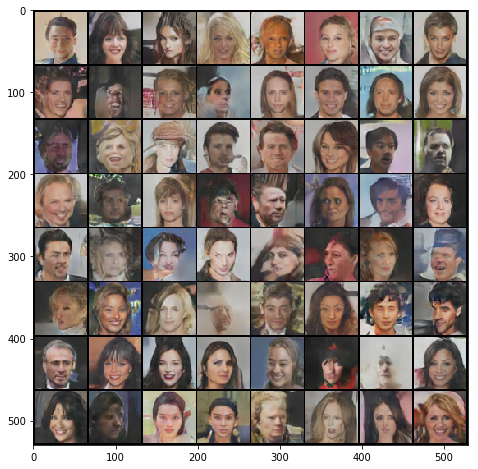

In [9]:
plt.figure(figsize=(8,8))
plt.imshow(img[-1])